In [247]:
import pandas as pd
import requests
import dotenv
import os
import json
from pathlib import Path
import numpy
from datetime import datetime
import dateutil.parser
import numpy as np

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [248]:
dotenv.load_dotenv()

True

In [249]:
start_date = '2018-01-20'

symbol = "CADUSD.FOREX"
asset = "CAD/USD"

eod_api_key = os.getenv("EOD_API_KEY")
eod_option = {'api_token': eod_api_key, 'order': 'd', 'fmt': 'json', 'from': start_date}
eod_option

{'api_token': '5fa212b3754234.49376057',
 'order': 'd',
 'fmt': 'json',
 'from': '2018-01-20'}

In [250]:
eod_request_url = "https://eodhistoricaldata.com/api/eod/" + symbol
#eod_request_url = "https://eodhistoricaldata.com/api/eod/MSFT.US?api_token=5fa212b3754234.49376057"
eod_request_url

'https://eodhistoricaldata.com/api/eod/CADUSD.FOREX'

### Execute GET request with API key

In [251]:
# Execute get request
eod_response_data = requests.get(eod_request_url, eod_option)
#response_content = eod_response_data.content
#print(response_content)
eod_data = eod_response_data.json()
#print(json.dumps(eod_data, indent=4))

In [252]:
column_list = ['DayID', 'Close']
eod_df = pd.DataFrame(columns=column_list)

for dict in eod_data: 
    for list in dict: 
        if list == "date":
            temp_date = datetime.strptime(dict[list], '%Y-%m-%d')
            #print(temp_date)
        elif list == "adjusted_close":
            temp_close = dict[list] 
            
    new_row = {'DayID':temp_date, 'Close':temp_close, 'Symbol':asset}
    eod_df = eod_df.append(new_row, ignore_index=True)                 
    
eod_df = eod_df.set_index(['DayID']) 
eod_df = eod_df.sort_index()
eod_df.head()

,Close,Symbol
DayID,,
2018-01-22,0.8036,CAD/USD
2018-01-23,0.8054,CAD/USD
2018-01-24,0.8098,CAD/USD
2018-01-25,0.8076,CAD/USD
2018-01-26,0.8123,CAD/USD


In [253]:
# Drop NAs and Calculate Daily Returns 

eod_df.columns = ['Close', 'Symbol']
eod_df['daily_return'] = eod_df['Close'].dropna().pct_change()
eod_df.head()

,Close,Symbol,daily_return
DayID,,,
2018-01-22,0.8036,CAD/USD,NaN
2018-01-23,0.8054,CAD/USD,0.002240
2018-01-24,0.8098,CAD/USD,0.005463
2018-01-25,0.8076,CAD/USD,-0.002717
2018-01-26,0.8123,CAD/USD,0.005820


### Construct Exponential Moving Average of Closing Prices (Trading Signal, Feature One)

In [254]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
eod_df['fast_close'] = eod_df['Close'].ewm(halflife=short_window).mean()
eod_df['slow_close'] = eod_df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
eod_df['crossover_long'] = np.where(eod_df['fast_close'] > eod_df['slow_close'], 1.0, 0.0)
eod_df['crossover_short'] = np.where(eod_df['fast_close'] < eod_df['slow_close'], -1.0, 0.0)
eod_df['crossover_signal'] = eod_df['crossover_long'] + eod_df['crossover_short']

eod_df.head()

,Close,Symbol,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
DayID,,,,,,,,
2018-01-22,0.8036,CAD/USD,NaN,0.803600,0.803600,0.0,0.0,0.0
2018-01-23,0.8054,CAD/USD,0.002240,0.804800,0.804531,1.0,0.0,1.0
2018-01-24,0.8098,CAD/USD,0.005463,0.807657,0.806410,1.0,0.0,1.0
2018-01-25,0.8076,CAD/USD,-0.002717,0.807627,0.806739,1.0,0.0,1.0
2018-01-26,0.8123,CAD/USD,0.005820,0.810039,0.808011,1.0,0.0,1.0


### Plot Exponential Moving Average of Closing Prices

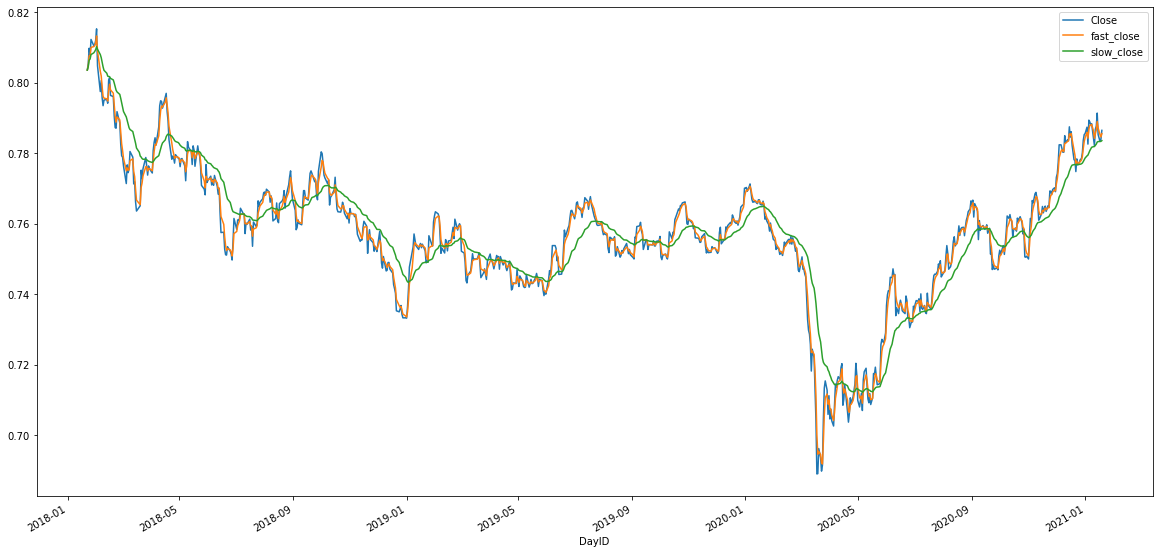

In [255]:
# Plot the EMA of CAD/USD closing prices
#!python -m pip install -U matplotlib

eod_df[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

### Construct Exponential Moving Average of Daily Return Volatility (Trading Signal, Feature Two)

In [256]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
eod_df['fast_vol'] = eod_df['daily_return'].ewm(halflife=short_vol_window).std()
eod_df['slow_vol'] = eod_df['daily_return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
eod_df['vol_trend_long'] = np.where(eod_df['fast_vol'] < eod_df['slow_vol'], 1.0, 0.0)
eod_df['vol_trend_short'] = np.where(eod_df['fast_vol'] > eod_df['slow_vol'], -1.0, 0.0) 
eod_df['vol_trend_signal'] = eod_df['vol_trend_long'] + eod_df['vol_trend_short']

eod_df.head()

,Close,Symbol,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
DayID,,,,,,,,,,,,,
2018-01-22,0.8036,CAD/USD,NaN,0.803600,0.803600,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2018-01-23,0.8054,CAD/USD,0.002240,0.804800,0.804531,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0
2018-01-24,0.8098,CAD/USD,0.005463,0.807657,0.806410,1.0,0.0,1.0,0.002279,0.002279,0.0,-1.0,-1.0
2018-01-25,0.8076,CAD/USD,-0.002717,0.807627,0.806739,1.0,0.0,1.0,0.004834,0.004199,0.0,-1.0,-1.0
2018-01-26,0.8123,CAD/USD,0.005820,0.810039,0.808011,1.0,0.0,1.0,0.004699,0.004029,0.0,-1.0,-1.0


### Plot Exponential Moving Average of Daily Return Volatility

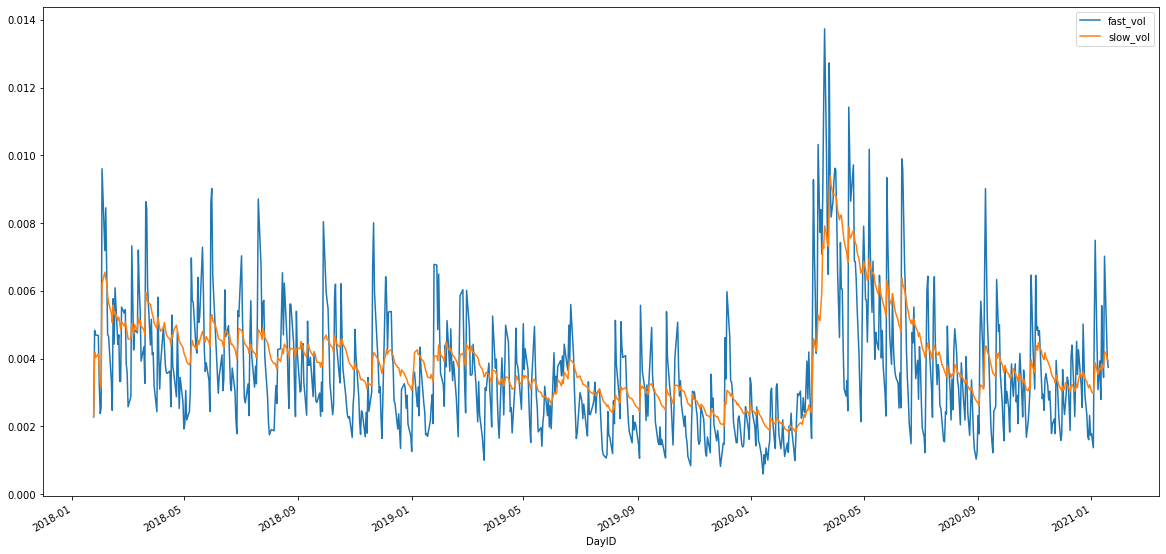

In [257]:
# Plot the EMA of CAD/USD daily return volatility
eod_df[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

### Construct Bollinger Band (Trading Signal, Feature Three)

In [258]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
eod_df['bollinger_mid_band'] = eod_df['Close'].rolling(window=bollinger_window).mean()
eod_df['bollinger_std'] = eod_df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
eod_df['bollinger_upper_band']  = eod_df['bollinger_mid_band'] + (eod_df['bollinger_std'] * 1)
eod_df['bollinger_lower_band']  = eod_df['bollinger_mid_band'] - (eod_df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
eod_df['bollinger_long'] = np.where(eod_df['Close'] < eod_df['bollinger_lower_band'], 1.0, 0.0)
eod_df['bollinger_short'] = np.where(eod_df['Close'] > eod_df['bollinger_upper_band'], -1.0, 0.0)
eod_df['bollinger_signal'] = eod_df['bollinger_long'] + eod_df['bollinger_short']

eod_df

,Close,Symbol,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
DayID,,,,,,,,,,,,,,,,,,,,
2018-01-22,0.8036,CAD/USD,NaN,0.803600,0.803600,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-23,0.8054,CAD/USD,0.002240,0.804800,0.804531,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-24,0.8098,CAD/USD,0.005463,0.807657,0.806410,1.0,0.0,1.0,0.002279,0.002279,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-25,0.8076,CAD/USD,-0.002717,0.807627,0.806739,1.0,0.0,1.0,0.004834,0.004199,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-26,0.8123,CAD/USD,0.005820,0.810039,0.808011,1.0,0.0,1.0,0.004699,0.004029,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-14,0.7914,CAD/USD,0.004697,0.789006,0.783184,1.0,0.0,1.0,0.003445,0.003745,1.0,0.0,1.0,0.784040,0.004586,0.788626,0.779454,0.0,-1.0,-1.0
2021-01-15,0.7853,CAD/USD,-0.007708,0.787153,0.783325,1.0,0.0,1.0,0.007020,0.004211,0.0,-1.0,-1.0,0.784385,0.004395,0.788780,0.779990,0.0,0.0,0.0
2021-01-17,0.7834,CAD/USD,-0.002419,0.785276,0.783330,1.0,0.0,1.0,0.004964,0.004121,0.0,-1.0,-1.0,0.784720,0.004017,0.788737,0.780703,0.0,0.0,0.0


### **Plot Bollinger Bands**

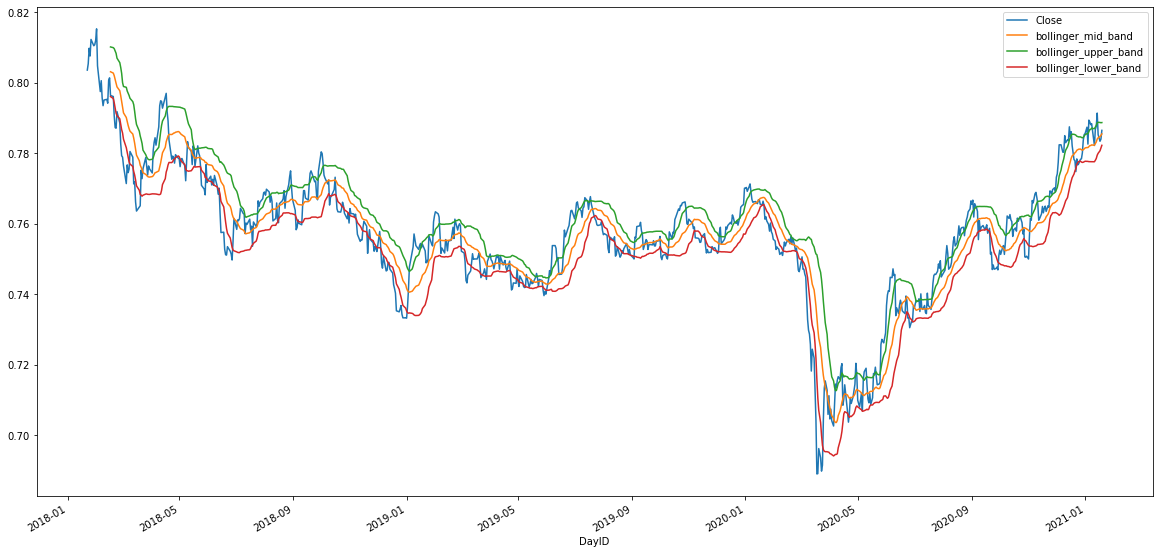

In [259]:
# Plot the Bollinger Bands for closing prices
eod_df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

### **Reading the Sentiment data**

In [260]:
file_path = Path("daily_sentiment.csv")
daily_sentiment= pd.read_csv(file_path, index_col=0)

daily_sentiment

,mean_sentiment,mean_compound
DayID,,
2018-01-20,0.511278,0.102247
2018-01-21,0.620690,0.211092
2018-01-22,0.533784,0.091852
2018-01-23,0.554770,0.133828
2018-01-24,0.510870,0.062822
...,...,...
2021-01-15,0.574007,0.175040
2021-01-16,0.574661,0.141493
2021-01-17,0.570248,0.143250


In [261]:
eod_df = pd.merge(eod_df,daily_sentiment,left_index=True, right_index=True).copy()
eod_df

,Close,Symbol,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,...,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,mean_sentiment,mean_compound
DayID,,,,,,,,,,,,,,,,,,,,,
2018-01-22,0.8036,CAD/USD,NaN,0.803600,0.803600,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.533784,0.091852
2018-01-23,0.8054,CAD/USD,0.002240,0.804800,0.804531,1.0,0.0,1.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.554770,0.133828
2018-01-24,0.8098,CAD/USD,0.005463,0.807657,0.806410,1.0,0.0,1.0,0.002279,0.002279,...,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.510870,0.062822
2018-01-25,0.8076,CAD/USD,-0.002717,0.807627,0.806739,1.0,0.0,1.0,0.004834,0.004199,...,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.545455,0.117320
2018-01-26,0.8123,CAD/USD,0.005820,0.810039,0.808011,1.0,0.0,1.0,0.004699,0.004029,...,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.591549,0.173912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-14,0.7914,CAD/USD,0.004697,0.789006,0.783184,1.0,0.0,1.0,0.003445,0.003745,...,1.0,0.784040,0.004586,0.788626,0.779454,0.0,-1.0,-1.0,0.505535,0.102336
2021-01-15,0.7853,CAD/USD,-0.007708,0.787153,0.783325,1.0,0.0,1.0,0.007020,0.004211,...,-1.0,0.784385,0.004395,0.788780,0.779990,0.0,0.0,0.0,0.574007,0.175040
2021-01-17,0.7834,CAD/USD,-0.002419,0.785276,0.783330,1.0,0.0,1.0,0.004964,0.004121,...,-1.0,0.784720,0.004017,0.788737,0.780703,0.0,0.0,0.0,0.570248,0.143250


### Dop the last row of the dataframe to remove the bad sentiment data

In [262]:
eod_df.drop(eod_df.tail(1).index,inplace=True)
eod_df

,Close,Symbol,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,...,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,mean_sentiment,mean_compound
DayID,,,,,,,,,,,,,,,,,,,,,
2018-01-22,0.8036,CAD/USD,NaN,0.803600,0.803600,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.533784,0.091852
2018-01-23,0.8054,CAD/USD,0.002240,0.804800,0.804531,1.0,0.0,1.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.554770,0.133828
2018-01-24,0.8098,CAD/USD,0.005463,0.807657,0.806410,1.0,0.0,1.0,0.002279,0.002279,...,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.510870,0.062822
2018-01-25,0.8076,CAD/USD,-0.002717,0.807627,0.806739,1.0,0.0,1.0,0.004834,0.004199,...,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.545455,0.117320
2018-01-26,0.8123,CAD/USD,0.005820,0.810039,0.808011,1.0,0.0,1.0,0.004699,0.004029,...,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.591549,0.173912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-13,0.7877,CAD/USD,0.001144,0.786612,0.782594,1.0,0.0,1.0,0.003942,0.003715,...,-1.0,0.783210,0.004685,0.787895,0.778525,0.0,0.0,0.0,0.468750,0.068546
2021-01-14,0.7914,CAD/USD,0.004697,0.789006,0.783184,1.0,0.0,1.0,0.003445,0.003745,...,1.0,0.784040,0.004586,0.788626,0.779454,0.0,-1.0,-1.0,0.505535,0.102336
2021-01-15,0.7853,CAD/USD,-0.007708,0.787153,0.783325,1.0,0.0,1.0,0.007020,0.004211,...,-1.0,0.784385,0.004395,0.788780,0.779990,0.0,0.0,0.0,0.574007,0.175040


### Set X-Variable List and Filter to Obtain Associated Values

In [263]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal', 'mean_compound']

# Filter by x-variable list
eod_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,mean_compound
DayID,,,,
2021-01-13,1.0,-1.0,0.0,0.068546
2021-01-14,1.0,1.0,-1.0,0.102336
2021-01-15,1.0,-1.0,0.0,0.175040
2021-01-17,1.0,-1.0,0.0,0.143250
2021-01-18,1.0,-1.0,0.0,0.085961


### Shift the DataFrame Index by 1

In [264]:
# Shift DataFrame values by 1
eod_df[x_var_list] = eod_df[x_var_list].shift(1)
eod_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,mean_compound
DayID,,,,
2021-01-13,1.0,-1.0,0.0,0.099435
2021-01-14,1.0,-1.0,0.0,0.068546
2021-01-15,1.0,1.0,-1.0,0.102336
2021-01-17,1.0,-1.0,0.0,0.175040
2021-01-18,1.0,-1.0,0.0,0.143250


### Drop NAs and Replace Infs (Positive/Negative Infinity) 

In [265]:
# Drop NAs and replace positive/negative infinity values
eod_df.dropna(subset=x_var_list, inplace=True)
eod_df.dropna(subset=['daily_return'], inplace=True)
eod_df = eod_df.replace([np.inf, -np.inf], np.nan)
eod_df.head()

,Close,Symbol,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,...,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,mean_sentiment,mean_compound
DayID,,,,,,,,,,,,,,,,,,,,,
2018-01-23,0.8054,CAD/USD,0.002240,0.804800,0.804531,1.0,0.0,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.554770,0.091852
2018-01-24,0.8098,CAD/USD,0.005463,0.807657,0.806410,1.0,0.0,1.0,0.002279,0.002279,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.510870,0.133828
2018-01-25,0.8076,CAD/USD,-0.002717,0.807627,0.806739,1.0,0.0,1.0,0.004834,0.004199,...,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.545455,0.062822
2018-01-26,0.8123,CAD/USD,0.005820,0.810039,0.808011,1.0,0.0,1.0,0.004699,0.004029,...,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.591549,0.117320
2018-01-29,0.8105,CAD/USD,-0.002216,0.810273,0.808501,1.0,0.0,1.0,0.004680,0.004140,...,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.522034,0.173912


### Construct the Dependent Variable

In [266]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
eod_df['Positive Return'] = np.where(eod_df['daily_return'] > 0, 1.0, 0.0)
eod_df

,Close,Symbol,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,...,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,mean_sentiment,mean_compound,Positive Return
DayID,,,,,,,,,,,,,,,,,,,,,
2018-01-23,0.8054,CAD/USD,0.002240,0.804800,0.804531,1.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.554770,0.091852,1.0
2018-01-24,0.8098,CAD/USD,0.005463,0.807657,0.806410,1.0,0.0,1.0,0.002279,0.002279,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.510870,0.133828,1.0
2018-01-25,0.8076,CAD/USD,-0.002717,0.807627,0.806739,1.0,0.0,1.0,0.004834,0.004199,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.545455,0.062822,0.0
2018-01-26,0.8123,CAD/USD,0.005820,0.810039,0.808011,1.0,0.0,1.0,0.004699,0.004029,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.591549,0.117320,1.0
2018-01-29,0.8105,CAD/USD,-0.002216,0.810273,0.808501,1.0,0.0,1.0,0.004680,0.004140,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.522034,0.173912,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-13,0.7877,CAD/USD,0.001144,0.786612,0.782594,1.0,0.0,1.0,0.003942,0.003715,...,0.783210,0.004685,0.787895,0.778525,0.0,0.0,0.0,0.468750,0.099435,1.0
2021-01-14,0.7914,CAD/USD,0.004697,0.789006,0.783184,1.0,0.0,1.0,0.003445,0.003745,...,0.784040,0.004586,0.788626,0.779454,0.0,-1.0,0.0,0.505535,0.068546,1.0
2021-01-15,0.7853,CAD/USD,-0.007708,0.787153,0.783325,1.0,0.0,1.0,0.007020,0.004211,...,0.784385,0.004395,0.788780,0.779990,0.0,0.0,-1.0,0.574007,0.102336,0.0


### Splitting Data Between Training and Testing Sets

To avoid the dataset being randomized, we will manually split the data using array slicing.

In [267]:
# Construct the X and y datasets
X= eod_df[x_var_list]
y = eod_df['Positive Return']
z = eod_df['daily_return']

### Separate X and y Training Datasets

In [268]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]

In [269]:
y_train.tail()

DayID
2020-03-25    1.0
2020-03-26    1.0
2020-03-27    1.0
2020-03-29    0.0
2020-03-30    0.0
Name: Positive Return, dtype: float64

In [270]:
y_test.tail()

DayID
2021-01-13    1.0
2021-01-14    1.0
2021-01-15    0.0
2021-01-17    0.0
2021-01-18    1.0
Name: Positive Return, dtype: float64

### Import SKLearn Library and Classes

In [271]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

### Train Random Forest Model 

In [272]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results["Return"] = eod_df['daily_return'][split:]
Results

,Positive Return,Predicted Value,Return
DayID,,,
2020-03-31,1.0,0.0,0.007508
2020-04-01,0.0,0.0,-0.009280
2020-04-02,1.0,0.0,0.003974
2020-04-03,0.0,0.0,-0.004665
2020-04-05,0.0,1.0,-0.002130
...,...,...,...
2021-01-13,1.0,0.0,0.001144
2021-01-14,1.0,0.0,0.004697
2021-01-15,0.0,1.0,-0.007708


### Save Pre-Trained Model Using Joblib

In [273]:
# Save the pre-trained model
from joblib import dump, load
dump(model, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [274]:
X_test.head()

,crossover_signal,vol_trend_signal,bollinger_signal,mean_compound
DayID,,,,
2020-03-31,-1.0,-1.0,0.0,-0.170997
2020-04-01,-1.0,-1.0,0.0,-0.047180
2020-04-02,-1.0,-1.0,0.0,-0.197366
2020-04-03,-1.0,1.0,0.0,-0.211672
2020-04-05,-1.0,1.0,0.0,-0.118908


In [275]:
Results.head()

,Positive Return,Predicted Value,Return
DayID,,,
2020-03-31,1.0,0.0,0.007508
2020-04-01,0.0,0.0,-0.009280
2020-04-02,1.0,0.0,0.003974
2020-04-03,0.0,0.0,-0.004665
2020-04-05,0.0,1.0,-0.002130


### Plot Predicted Results vs. Actual Results

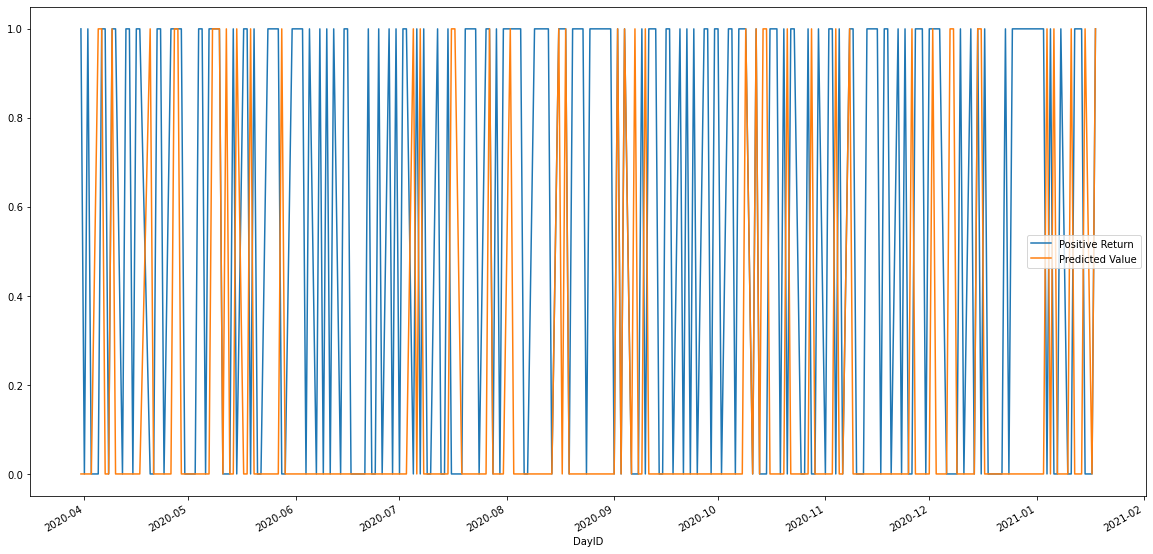

In [276]:
# Plot predicted results vs. actual results
Results[['Positive Return', 'Predicted Value']].plot(figsize=(20,10))

### Plot Predicted Results vs. Actual Results (of last 10 records)

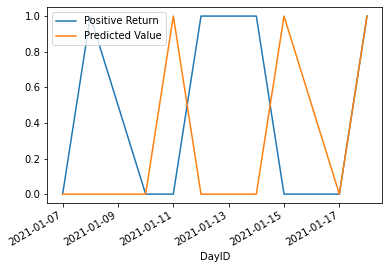

In [277]:
# Plot last 10 records of predicted vs. actual results
Results[['Positive Return', 'Predicted Value']].tail(10).plot()

### Replace Predicted Values 0 as -1 (For shorting)

In [278]:
# Replace predicted values 0 to -1 to account for shorting
Results['Predicted Value'].replace(0, -1, inplace=True)
Results

,Positive Return,Predicted Value,Return
DayID,,,
2020-03-31,1.0,-1.0,0.007508
2020-04-01,0.0,-1.0,-0.009280
2020-04-02,1.0,-1.0,0.003974
2020-04-03,0.0,-1.0,-0.004665
2020-04-05,0.0,1.0,-0.002130
...,...,...,...
2021-01-13,1.0,-1.0,0.001144
2021-01-14,1.0,-1.0,0.004697
2021-01-15,0.0,1.0,-0.007708


### Plot Cumulative Returns of Random Forest Model

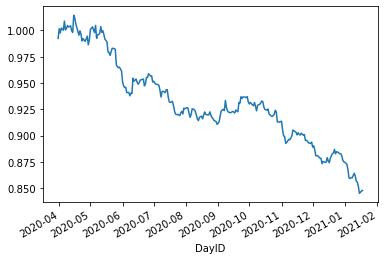

In [279]:
# Calculate cumulative return of model and plot the result
(1 + (Results['Return'] * Results['Predicted Value'])).cumprod().plot()

### Plot Cumulative Return of Random Forest Model (In Terms of Capital)

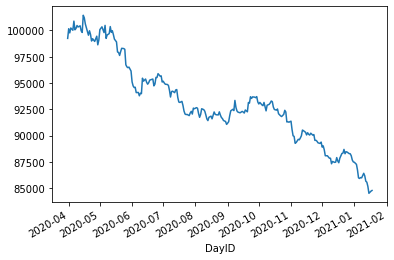

In [280]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (Results['Return'] * Results['Predicted Value'])).cumprod()
cumulative_return_capital.plot()

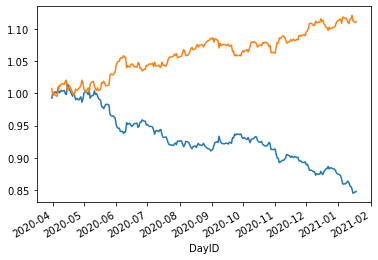

In [281]:
(1 + (Results['Return'] * Results['Predicted Value'])).cumprod().plot()
(1 + (Results['Return'])).cumprod().plot()